# DataWorkshop

# Use NLP to detect a fake news

# Top 2

In [1]:
import pandas as pd
import numpy as np
np.random.seed(0)
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression


from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import tensorflow as tf
from tensorflow import keras
from textblob import TextBlob
import catboost as ctb
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from scikitplot.estimators import plot_learning_curve
from keras_bert import load_trained_model_from_checkpoint
from transformers import BertTokenizer
import shap

from gensim.models import FastText
from gensim.utils import simple_preprocess, to_utf8
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

import spacy
from wordcloud import STOPWORDS


from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

from gensim.models.phrases import Phraser
from gensim.models import Word2Vec, Phrases
import spacy
import joblib

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def get_doc2vec_X(model, tokens):
    def __calc_doc2vec(words):   
        return np.mean([model.wv[w] for w in words if w in model.wv], axis=0)

    X = tokens.map(__calc_doc2vec)
    default_vector = X[ False == X.isnull() ].mean()
    return np.stack( X.map(lambda x: default_vector if str(x) == 'nan' else x) )

In [3]:
def init_tokenizer_and_load_bert(model_name='uncased_L-2_H-128_A-2', do_lower_case=True, model_trainable=False):
    model_dir = '/home/hubert.charewicz_1057/nlp1/module4/models/{}'.format(model_name)

    config_path = model_dir + '/bert_config.json'
    checkpoint_path = model_dir +'/bert_model.ckpt'
    vocab_path = model_dir + '/vocab.txt'
    
    print("loading: {}".format(model_name))
    
    tokenizer = BertTokenizer(vocab_path)
    print("vocab size: {}".format(len(tokenizer.vocab)))
    
    model = load_trained_model_from_checkpoint(config_path, checkpoint_path, training=model_trainable)
    print("loaded: {}".format(model_name))
    
    return tokenizer, model

In [4]:
def get_FastText_X(model, tokens):
    def __calc_doc2vec(words):   
        return np.mean([model.wv[w] for w in words if w in model.wv], axis=0)

    X = tokens.map(__calc_doc2vec)
    default_vector = X[ False == X.isnull() ].mean()
    return np.stack( X.map(lambda x: default_vector if str(x) == 'nan' else x) )

In [5]:
train = pd.read_hdf("../input/train_fake.h5")
test = pd.read_hdf("../input/test_fake.h5")

test['is_fake'] = 0

train['date'] = 'train'
test['date'] = 'test'


df = pd.concat([train,test])

df['text'] = df['text'].fillna('unknown')
df['title'] = df['title'].fillna('unknown')
df['title_text'] = df['title'] + " " + df['text']
y = df['is_fake']

# simple_preprocess

In [6]:
df['simple_tokens_title_text'] = df['title_text'].map(simple_preprocess)
df['simple_tokens_text'] = df['text'].map(simple_preprocess)
df['simple_tokens_title'] = df['title'].map(simple_preprocess)


## Meta features

In [7]:
df['n_token_title'] = df['simple_tokens_title'].map(lambda x: len(x))
df['n_token_text'] = df['simple_tokens_text'].map(lambda x: len(x))
df['n_unique_token_title'] = df['simple_tokens_title'].map(lambda x: len(set(x)))
df['n_unique_token_text'] = df['simple_tokens_text'].map(lambda x: len(set(x)))

df['len_title'] = df['title'].map(lambda x: len(x))
df['len_text'] = df['text'].map(lambda x: len(x))
df['len_text_title'] = df['title_text'].map(lambda x: len(x))

df['n_title_stopword'] = df['simple_tokens_title'].map(lambda x: len( [word for word in x if word in STOPWORDS] ) )
df['n_text_stopword'] = df['simple_tokens_text'].map(lambda x: len( [word for word in x if word in STOPWORDS] ) )

(4862, 9)
CPU times: user 822 ms, sys: 0 ns, total: 822 ms
Wall time: 99.6 ms


(0.638, 0.004)

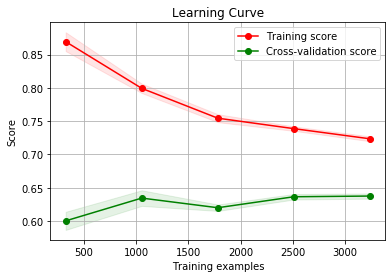

In [8]:
features = [
       'n_token_title', 'n_token_text', 'n_unique_token_title',
       'n_unique_token_text', 'len_title', 'len_text', 'len_text_title',
       'n_title_stopword', 'n_text_stopword']
X = df[features]
X_train = X[:4862]
X_test = X[4862:]
print(X_train.shape)
y_train = y[:4862]

model = lgb.LGBMClassifier(max_depth=2, n_estimators=150, random_state=0)
%time scores = cross_val_score(model, X_train, y_train, cv=3, scoring='roc_auc')
plot_learning_curve(model, X_train, y_train, cv=3, scoring='roc_auc')
round(np.mean(scores),3), round(np.std(scores),3)

In [9]:
model = lgb.LGBMClassifier(max_depth = 2, n_estimators=150)
model.fit(X_train,y_train)
# #train['pred'] = model.predict(X_train)
test['is_fake'] = model.predict_proba(X_test)[:, 1]

In [10]:
test[ ['id', 'is_fake'] ].to_csv('meta_features.csv', index=False)

# Word2vec: Title / Title_Text


In [11]:
#Title
tokens = df['simple_tokens_title']
model = Word2Vec(tokens, size=300, window=5,sg=1,hs=1 ,seed=0)
X_simple_tokens_title = get_doc2vec_X(model, tokens)


X_simple_tokens_title_ = X_simple_tokens_title[:4862]
y_train = y[:4862]

Mean of empty slice.
invalid value encountered in double_scalars


In [12]:
model = lgb.LGBMClassifier(max_depth=2, n_estimators=50, random_state=0)
%time scores = cross_val_score(model, X_simple_tokens_title_, y_train, cv=3, scoring='roc_auc')
#plot_learning_curve(model,X_simple_tokens_title, y_train, cv=3, scoring='roc_auc') 
np.mean(scores), np.std(scores)

CPU times: user 2.95 s, sys: 39 ms, total: 2.99 s
Wall time: 364 ms


(0.6488305678894865, 0.006497912165981582)

In [13]:
#Text and Title
tokens = df['simple_tokens_title_text']
model = Word2Vec(tokens, size=500, window=5,sg=1,hs=1 ,seed=0)
X_simple_tokens_title_text500 = get_doc2vec_X(model, tokens)


X_simple_tokens_title_text500_ = X_simple_tokens_title_text500[:4862]
y_train = y[:4862]


model = lgb.LGBMClassifier(max_depth=2, n_estimators=50, random_state=0)
%time scores = cross_val_score(model, X_simple_tokens_title_text500_, y_train, cv=3, scoring='roc_auc')
#plot_learning_curve(model,X_simple_tokens_title, y_train, cv=3, scoring='roc_auc') 
np.mean(scores), np.std(scores)

CPU times: user 4.93 s, sys: 39.4 ms, total: 4.97 s
Wall time: 605 ms


(0.6974563680155773, 0.009480787397781408)

# Spacy_lg  + Bert 128: Title

In [14]:
nlp = spacy.load("en_core_web_lg")

df['simple_tokens_title_spacylg'] = df['title'].map(lambda x : nlp(x))
df['simple_tokens_title_spacylg'] = df['title'].map( lambda x : [word for word in x.split()])

In [15]:
tokenizer, model = init_tokenizer_and_load_bert('uncased_L-2_H-128_A-2', model_trainable=True)

loading: uncased_L-2_H-128_A-2
vocab size: 30522
loaded: uncased_L-2_H-128_A-2


In [16]:
tokenize = lambda sent: tokenizer.encode_plus(sent, max_length=512, padding='max_length', truncation=True)
%time df['simple_tokens_title_spacylg'] = df['simple_tokens_title_spacylg'].map(tokenize)

CPU times: user 880 ms, sys: 44 ms, total: 924 ms
Wall time: 929 ms


In [17]:
df['input_ids_title_spacy'] = df['simple_tokens_title_spacylg'].map(lambda t: t['input_ids'] )
df['token_type_ids_title_spacy'] = df['simple_tokens_title_spacylg'].map(lambda t: t['token_type_ids'] )
df['attention_mask_title_spacy'] = df['simple_tokens_title_spacylg'].map(lambda t: t['attention_mask'] )


input_ids_title_spacy = np.stack(df['input_ids_title_spacy'])
token_type_ids_title_spacy = np.stack(df['token_type_ids_title_spacy'])
attention_mask_title_spacy = np.stack(df['attention_mask_title_spacy'])

In [18]:
tokenizer, model = init_tokenizer_and_load_bert('uncased_L-2_H-128_A-2', model_trainable=True)

loading: uncased_L-2_H-128_A-2
vocab size: 30522
loaded: uncased_L-2_H-128_A-2


In [ ]:
%time predicts = model.predict([input_ids_title_spacy, token_type_ids_title_spacy, attention_mask_title_spacy], verbose=1)

 38/304 [==>...........................] - ETA:  - ETA: 5: - ETA: 7: - ETA: 8: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 10:0 - ETA: 10:0 - ETA: 10:0 - ETA: 10:0 - ETA: 10:0 - ETA: 10:0 - ETA: 10:0 - ETA: 10:0 - ETA: 10:1 - ETA: 10:2 - ETA: 10:1 - ETA: 10:1 - ETA: 10:1 - ETA: 10:1 - ETA: 10:1 - ETA: 10:1 - ETA: 10:1 - ETA: 10:0 - ETA: 10:0 - ETA: 10:0 - ETA: 10:0 - ETA: 10:0 - ETA: 10:0 - ETA: 10:0 - ETA: 9:5 - ETA: 10:0 - ETA: 9:5 - ETA: 9: - ETA: 9: - ETA: 9:51

In [ ]:
joblib.dump(predicts,"X_title_after_sapcylg.joblib")

# Bert 512: Title/Text

In [ ]:
tokenizer, model = init_tokenizer_and_load_bert('uncased_L-4_H-512_A-8', model_trainable=True)

In [ ]:
tokenize = lambda sent: tokenizer.encode_plus(sent, max_length=512, padding='max_length', truncation=True)
%time df['simple_tokens_title'] = df['title'].map(tokenize)
%time df['simple_tokens_text'] = df['text'].map(tokenize)
%time df['simple_tokens_title'] = df['title_text'].map(tokenize)

In [ ]:
df['input_ids'] = df['simple_tokens_text'].map(lambda t: t['input_ids'] )
df['token_type_ids'] = df['simple_tokens_text'].map(lambda t: t['token_type_ids'] )
df['attention_mask'] = df['simple_tokens_text'].map(lambda t: t['attention_mask'] )

df['input_ids_title'] = df['simple_tokens_title'].map(lambda t: t['input_ids'] )
df['token_type_ids_title'] = df['simple_tokens_title'].map(lambda t: t['token_type_ids'] )
df['attention_mask_title'] = df['simple_tokens_title'].map(lambda t: t['attention_mask'] )


In [ ]:
input_ids = np.stack(df['input_ids'])
token_type_ids = np.stack(df['token_type_ids'])
attention_mask = np.stack(df['attention_mask'])

input_ids_title = np.stack(df['input_ids_title'])
token_type_ids_title = np.stack(df['token_type_ids_title'])
attention_mask_title = np.stack(df['attention_mask_title'])

In [ ]:
#Bert tylko na title
%time predicts_title_512 = model.predict([input_ids_title, token_type_ids_title, attention_mask_title], verbose=1)

In [ ]:
joblib.dump(predicts_title_512,"predicts_title512model.joblib")

# Bert + Phraser: Title

In [ ]:
tokens = df['simple_tokens_title']
bigram = Phrases(tokens, min_count=2, threshold=2)
bigram_phraser = Phraser(bigram)
df['title_phraser'] = df['title'].map(lambda doc: bigram_phraser[doc])

In [ ]:
tokenizer, bert_model = init_tokenizer_and_load_bert('uncased_L-2_H-128_A-2')

In [ ]:
tokenize = lambda sent: tokenizer.encode_plus(sent, max_length=512, padding='max_length', truncation=True)
%time df['tokens_title'] = df['title'].map(tokenize)

In [ ]:
df['input_ids_title'] = df['tokens_title'].map(lambda t: t['input_ids'] )
df['token_type_ids_title'] = df['tokens_title'].map(lambda t: t['token_type_ids'] )
df['attention_mask_title'] = df['tokens_title'].map(lambda t: t['attention_mask'] )

input_ids_title = np.stack(df['input_ids_title'])
token_type_ids_title = np.stack(df['token_type_ids_title'])
attention_mask_title = np.stack(df['attention_mask_title'])

In [ ]:
%time predicts = bert_model.predict([input_ids_title, token_type_ids_title, attention_mask_title], verbose=1)

In [ ]:
joblib.dump(predicts,"X_tilte_phraser.joblib")

# Fasttext

In [14]:
tokens = df['simple_tokens_title_text']
model = FastText(tokens, size=200, word_ngrams=5, window=4, seed=0, sg = 1, hs =1)
X_title_text_simple_fasttext = get_FastText_X(model, tokens)

In [15]:
def train_model(X):    

    y_train = y[:4862]

    print(X.shape)
    model = lgb.LGBMClassifier(max_depth=2, n_estimators=150, random_state=0)
    scores = cross_val_score(model, X[:4862], y_train, cv=3, scoring='roc_auc')
    print(round(np.mean(scores),3), round(np.std(scores),3))
    plot_learning_curve(model,X[:4862], y_train, cv=3, scoring='roc_auc') 
    plt.show()


In [21]:
# Wektory Berta - wczytanie

predicts_afterspacylg = joblib.load( "/home/hubert.charewicz_1057/nlp1/module5/notebooks/X_title_after_sapcylg.joblib")
predicts_title512model = joblib.load("predicts_title512model.joblib")
X_tilte_phraser = joblib.load("X_tilte_phraser.joblib")


predicts_afterspacylg = predicts_afterspacylg[:, 0 , :]
predicts_title512model = predicts_title512model[:, 0 , :] 
X_tilte_phraser = X_tilte_phraser[:, 0 , :]

In [22]:
#Wektory Piotrka 

dir_vec =  '/home/hubert.charewicz_1057/nlp1/module5/models/vectors_piotrek/{}'
X_train1 = np.load(dir_vec.format('train_X_text_cased_L-12_H-768_A-12.npy'))
X_test1 = np.load(dir_vec.format('test_X_text_cased_L-12_H-768_A-12.npy'))

X_train1 = np.concatenate([X_train1,X_test1],axis = 0)

In [23]:
zbiory =    {"X_simple_tokens_title":X_simple_tokens_title, 
            "X_simple_tokens_title_text500":X_simple_tokens_title_text500,  
            "X_title_text_simple_fasttext":X_title_text_simple_fasttext, 
        
            "predicts_afterspacylg":predicts_afterspacylg,
            "predicts_title512model":predicts_title512model,
            "X_tilte_phraser":X_tilte_phraser,  
            "X_train1":X_train1}

# Sprawdzmy pojedyncze wektory

X_simple_tokens_title
(9725, 300)
0.656 0.005


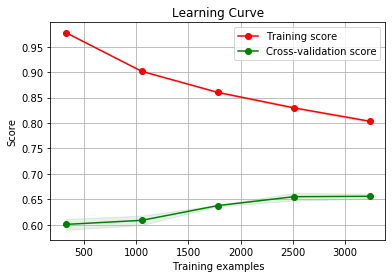

X_simple_tokens_title_text500
(9725, 500)
0.711 0.007


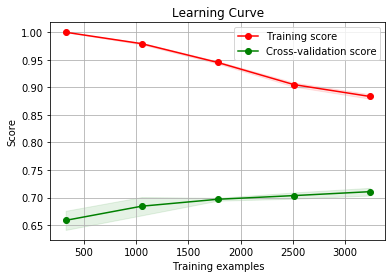

X_title_text_simple_fasttext
(9725, 200)
0.708 0.008


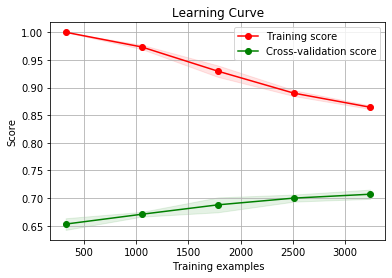

predicts_afterspacylg
(9725, 128)
0.649 0.008


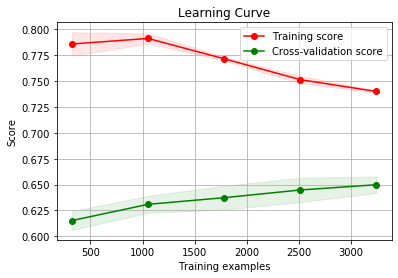

predicts_title512model
(9725, 128)
0.672 0.007


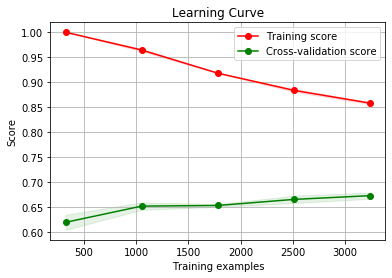

X_tilte_phraser
(9725, 128)
0.659 0.005


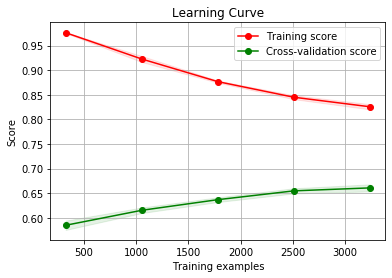

X_train1
(9725, 768)
0.646 0.009


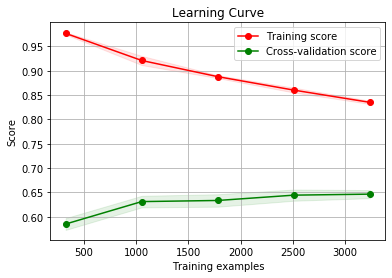

In [24]:
for name, zbior in zbiory.items():
    print(name)
    train_model(zbior)

# Złączenie

(9725, 2152)
0.744 0.008


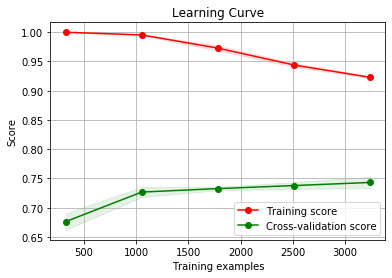

In [25]:
X = np.concatenate([
            X_simple_tokens_title, #word2vec - Title
            X_simple_tokens_title_text500, #word2vec 500 - Title and Text 
            X_title_text_simple_fasttext, #fasttext  - Title and Text
        
            predicts_afterspacylg,
            predicts_title512model, #Bert 512 - Title
            X_tilte_phraser,  #Bert 128 = Title + phraser
            X_train1],  # Bert od Piotrka 768 cased ,
    axis =1)


train_model(X)

In [31]:
X.shape

(9725, 2152)

# Predykcja 

In [33]:
X_train = X[:4862]
X_test = X[4862:]
print(X_train.shape)
y_train = y[:4862]

HuBERT = ctb.CatBoostClassifier(max_depth=7, n_estimators=3000, random_state=0)
HuBERT.fit(X_train,y_train)
test['is_fake'] = HuBERT.predict_proba(X_test)[:, 1]

(4862, 2152)
Learning rate set to 0.007391
0:	learn: 0.6912343	total: 252ms	remaining: 12m 34s
1:	learn: 0.6893869	total: 392ms	remaining: 9m 47s
2:	learn: 0.6880139	total: 534ms	remaining: 8m 53s
3:	learn: 0.6866951	total: 677ms	remaining: 8m 27s
4:	learn: 0.6853027	total: 816ms	remaining: 8m 8s
5:	learn: 0.6840992	total: 956ms	remaining: 7m 57s
6:	learn: 0.6826687	total: 1.1s	remaining: 7m 49s
7:	learn: 0.6811582	total: 1.24s	remaining: 7m 42s
8:	learn: 0.6795951	total: 1.38s	remaining: 7m 37s
9:	learn: 0.6780988	total: 1.52s	remaining: 7m 33s
10:	learn: 0.6766487	total: 1.66s	remaining: 7m 31s
11:	learn: 0.6752604	total: 1.8s	remaining: 7m 27s
12:	learn: 0.6740084	total: 1.94s	remaining: 7m 25s
13:	learn: 0.6725771	total: 2.08s	remaining: 7m 23s
14:	learn: 0.6711947	total: 2.22s	remaining: 7m 21s
15:	learn: 0.6697661	total: 2.36s	remaining: 7m 20s
16:	learn: 0.6683483	total: 2.5s	remaining: 7m 19s
17:	learn: 0.6670915	total: 2.64s	remaining: 7m 18s
18:	learn: 0.6659500	total: 2.78s	

158:	learn: 0.5731675	total: 22.6s	remaining: 6m 44s
159:	learn: 0.5727469	total: 22.8s	remaining: 6m 44s
160:	learn: 0.5724794	total: 22.9s	remaining: 6m 43s
161:	learn: 0.5720782	total: 23s	remaining: 6m 43s
162:	learn: 0.5716586	total: 23.2s	remaining: 6m 43s
163:	learn: 0.5712699	total: 23.3s	remaining: 6m 43s
164:	learn: 0.5708449	total: 23.5s	remaining: 6m 43s
165:	learn: 0.5704931	total: 23.6s	remaining: 6m 43s
166:	learn: 0.5701437	total: 23.8s	remaining: 6m 42s
167:	learn: 0.5698533	total: 23.9s	remaining: 6m 42s
168:	learn: 0.5694990	total: 24s	remaining: 6m 42s
169:	learn: 0.5690645	total: 24.2s	remaining: 6m 42s
170:	learn: 0.5686697	total: 24.3s	remaining: 6m 42s
171:	learn: 0.5682702	total: 24.5s	remaining: 6m 42s
172:	learn: 0.5678850	total: 24.6s	remaining: 6m 42s
173:	learn: 0.5675076	total: 24.7s	remaining: 6m 41s
174:	learn: 0.5671836	total: 24.9s	remaining: 6m 41s
175:	learn: 0.5667515	total: 25s	remaining: 6m 41s
176:	learn: 0.5664009	total: 25.2s	remaining: 6m 41s

314:	learn: 0.5253876	total: 44.7s	remaining: 6m 21s
315:	learn: 0.5251702	total: 44.9s	remaining: 6m 21s
316:	learn: 0.5248990	total: 45s	remaining: 6m 20s
317:	learn: 0.5246459	total: 45.2s	remaining: 6m 20s
318:	learn: 0.5243759	total: 45.3s	remaining: 6m 20s
319:	learn: 0.5240493	total: 45.4s	remaining: 6m 20s
320:	learn: 0.5237662	total: 45.6s	remaining: 6m 20s
321:	learn: 0.5235183	total: 45.7s	remaining: 6m 20s
322:	learn: 0.5231866	total: 45.9s	remaining: 6m 20s
323:	learn: 0.5229873	total: 46s	remaining: 6m 20s
324:	learn: 0.5226978	total: 46.2s	remaining: 6m 19s
325:	learn: 0.5223568	total: 46.3s	remaining: 6m 19s
326:	learn: 0.5220513	total: 46.4s	remaining: 6m 19s
327:	learn: 0.5217665	total: 46.6s	remaining: 6m 19s
328:	learn: 0.5215367	total: 46.7s	remaining: 6m 19s
329:	learn: 0.5212674	total: 46.9s	remaining: 6m 19s
330:	learn: 0.5209730	total: 47s	remaining: 6m 18s
331:	learn: 0.5206578	total: 47.1s	remaining: 6m 18s
332:	learn: 0.5203757	total: 47.3s	remaining: 6m 18s

472:	learn: 0.4877841	total: 1m 7s	remaining: 5m 58s
473:	learn: 0.4875848	total: 1m 7s	remaining: 5m 58s
474:	learn: 0.4872963	total: 1m 7s	remaining: 5m 58s
475:	learn: 0.4871242	total: 1m 7s	remaining: 5m 58s
476:	learn: 0.4869881	total: 1m 7s	remaining: 5m 58s
477:	learn: 0.4867792	total: 1m 7s	remaining: 5m 58s
478:	learn: 0.4865800	total: 1m 8s	remaining: 5m 58s
479:	learn: 0.4863170	total: 1m 8s	remaining: 5m 57s
480:	learn: 0.4860785	total: 1m 8s	remaining: 5m 57s
481:	learn: 0.4858603	total: 1m 8s	remaining: 5m 57s
482:	learn: 0.4856926	total: 1m 8s	remaining: 5m 57s
483:	learn: 0.4855411	total: 1m 8s	remaining: 5m 57s
484:	learn: 0.4852344	total: 1m 8s	remaining: 5m 57s
485:	learn: 0.4849947	total: 1m 9s	remaining: 5m 57s
486:	learn: 0.4848103	total: 1m 9s	remaining: 5m 56s
487:	learn: 0.4846041	total: 1m 9s	remaining: 5m 56s
488:	learn: 0.4844464	total: 1m 9s	remaining: 5m 56s
489:	learn: 0.4842878	total: 1m 9s	remaining: 5m 56s
490:	learn: 0.4841110	total: 1m 9s	remaining: 

625:	learn: 0.4579259	total: 1m 29s	remaining: 5m 37s
626:	learn: 0.4578054	total: 1m 29s	remaining: 5m 37s
627:	learn: 0.4576918	total: 1m 29s	remaining: 5m 37s
628:	learn: 0.4574990	total: 1m 29s	remaining: 5m 37s
629:	learn: 0.4573339	total: 1m 29s	remaining: 5m 36s
630:	learn: 0.4571526	total: 1m 29s	remaining: 5m 36s
631:	learn: 0.4569828	total: 1m 29s	remaining: 5m 36s
632:	learn: 0.4568351	total: 1m 29s	remaining: 5m 36s
633:	learn: 0.4566357	total: 1m 30s	remaining: 5m 36s
634:	learn: 0.4565130	total: 1m 30s	remaining: 5m 36s
635:	learn: 0.4563092	total: 1m 30s	remaining: 5m 36s
636:	learn: 0.4561652	total: 1m 30s	remaining: 5m 35s
637:	learn: 0.4560438	total: 1m 30s	remaining: 5m 35s
638:	learn: 0.4558733	total: 1m 30s	remaining: 5m 35s
639:	learn: 0.4557580	total: 1m 30s	remaining: 5m 35s
640:	learn: 0.4555784	total: 1m 31s	remaining: 5m 35s
641:	learn: 0.4554406	total: 1m 31s	remaining: 5m 35s
642:	learn: 0.4552302	total: 1m 31s	remaining: 5m 35s
643:	learn: 0.4550797	total:

777:	learn: 0.4321952	total: 1m 50s	remaining: 5m 15s
778:	learn: 0.4320950	total: 1m 50s	remaining: 5m 15s
779:	learn: 0.4319963	total: 1m 50s	remaining: 5m 15s
780:	learn: 0.4318659	total: 1m 50s	remaining: 5m 15s
781:	learn: 0.4316754	total: 1m 51s	remaining: 5m 15s
782:	learn: 0.4315160	total: 1m 51s	remaining: 5m 14s
783:	learn: 0.4313274	total: 1m 51s	remaining: 5m 14s
784:	learn: 0.4311575	total: 1m 51s	remaining: 5m 14s
785:	learn: 0.4309228	total: 1m 51s	remaining: 5m 14s
786:	learn: 0.4307786	total: 1m 51s	remaining: 5m 14s
787:	learn: 0.4305688	total: 1m 51s	remaining: 5m 14s
788:	learn: 0.4304185	total: 1m 52s	remaining: 5m 14s
789:	learn: 0.4302947	total: 1m 52s	remaining: 5m 13s
790:	learn: 0.4301290	total: 1m 52s	remaining: 5m 13s
791:	learn: 0.4299357	total: 1m 52s	remaining: 5m 13s
792:	learn: 0.4297543	total: 1m 52s	remaining: 5m 13s
793:	learn: 0.4296329	total: 1m 52s	remaining: 5m 13s
794:	learn: 0.4294142	total: 1m 52s	remaining: 5m 13s
795:	learn: 0.4292119	total:

933:	learn: 0.4070747	total: 2m 12s	remaining: 4m 53s
934:	learn: 0.4069903	total: 2m 12s	remaining: 4m 53s
935:	learn: 0.4068773	total: 2m 12s	remaining: 4m 53s
936:	learn: 0.4067243	total: 2m 13s	remaining: 4m 53s
937:	learn: 0.4065712	total: 2m 13s	remaining: 4m 52s
938:	learn: 0.4063731	total: 2m 13s	remaining: 4m 52s
939:	learn: 0.4062026	total: 2m 13s	remaining: 4m 52s
940:	learn: 0.4060808	total: 2m 13s	remaining: 4m 52s
941:	learn: 0.4059618	total: 2m 13s	remaining: 4m 52s
942:	learn: 0.4057727	total: 2m 13s	remaining: 4m 52s
943:	learn: 0.4057110	total: 2m 14s	remaining: 4m 52s
944:	learn: 0.4055472	total: 2m 14s	remaining: 4m 51s
945:	learn: 0.4053999	total: 2m 14s	remaining: 4m 51s
946:	learn: 0.4052633	total: 2m 14s	remaining: 4m 51s
947:	learn: 0.4050807	total: 2m 14s	remaining: 4m 51s
948:	learn: 0.4049416	total: 2m 14s	remaining: 4m 51s
949:	learn: 0.4047999	total: 2m 14s	remaining: 4m 51s
950:	learn: 0.4045891	total: 2m 15s	remaining: 4m 51s
951:	learn: 0.4044318	total:

1084:	learn: 0.3848195	total: 2m 34s	remaining: 4m 31s
1085:	learn: 0.3846858	total: 2m 34s	remaining: 4m 31s
1086:	learn: 0.3845563	total: 2m 34s	remaining: 4m 31s
1087:	learn: 0.3844427	total: 2m 34s	remaining: 4m 31s
1088:	learn: 0.3842880	total: 2m 34s	remaining: 4m 31s
1089:	learn: 0.3841310	total: 2m 34s	remaining: 4m 31s
1090:	learn: 0.3839855	total: 2m 34s	remaining: 4m 31s
1091:	learn: 0.3838632	total: 2m 35s	remaining: 4m 30s
1092:	learn: 0.3837117	total: 2m 35s	remaining: 4m 30s
1093:	learn: 0.3835886	total: 2m 35s	remaining: 4m 30s
1094:	learn: 0.3834513	total: 2m 35s	remaining: 4m 30s
1095:	learn: 0.3833352	total: 2m 35s	remaining: 4m 30s
1096:	learn: 0.3831284	total: 2m 35s	remaining: 4m 30s
1097:	learn: 0.3829602	total: 2m 35s	remaining: 4m 30s
1098:	learn: 0.3828308	total: 2m 36s	remaining: 4m 29s
1099:	learn: 0.3826504	total: 2m 36s	remaining: 4m 29s
1100:	learn: 0.3824643	total: 2m 36s	remaining: 4m 29s
1101:	learn: 0.3822685	total: 2m 36s	remaining: 4m 29s
1102:	lear

1233:	learn: 0.3622426	total: 2m 55s	remaining: 4m 10s
1234:	learn: 0.3621365	total: 2m 55s	remaining: 4m 10s
1235:	learn: 0.3619617	total: 2m 55s	remaining: 4m 10s
1236:	learn: 0.3617424	total: 2m 55s	remaining: 4m 10s
1237:	learn: 0.3616297	total: 2m 55s	remaining: 4m 10s
1238:	learn: 0.3614623	total: 2m 55s	remaining: 4m 9s
1239:	learn: 0.3613359	total: 2m 55s	remaining: 4m 9s
1240:	learn: 0.3611913	total: 2m 56s	remaining: 4m 9s
1241:	learn: 0.3610317	total: 2m 56s	remaining: 4m 9s
1242:	learn: 0.3609050	total: 2m 56s	remaining: 4m 9s
1243:	learn: 0.3607125	total: 2m 56s	remaining: 4m 9s
1244:	learn: 0.3605863	total: 2m 56s	remaining: 4m 9s
1245:	learn: 0.3604692	total: 2m 56s	remaining: 4m 8s
1246:	learn: 0.3603465	total: 2m 56s	remaining: 4m 8s
1247:	learn: 0.3602087	total: 2m 57s	remaining: 4m 8s
1248:	learn: 0.3600600	total: 2m 57s	remaining: 4m 8s
1249:	learn: 0.3598683	total: 2m 57s	remaining: 4m 8s
1250:	learn: 0.3597069	total: 2m 57s	remaining: 4m 8s
1251:	learn: 0.3594811	

1386:	learn: 0.3388915	total: 3m 16s	remaining: 3m 48s
1387:	learn: 0.3387660	total: 3m 16s	remaining: 3m 48s
1388:	learn: 0.3386659	total: 3m 17s	remaining: 3m 48s
1389:	learn: 0.3385173	total: 3m 17s	remaining: 3m 48s
1390:	learn: 0.3383375	total: 3m 17s	remaining: 3m 48s
1391:	learn: 0.3380914	total: 3m 17s	remaining: 3m 48s
1392:	learn: 0.3380270	total: 3m 17s	remaining: 3m 47s
1393:	learn: 0.3378343	total: 3m 17s	remaining: 3m 47s
1394:	learn: 0.3376598	total: 3m 17s	remaining: 3m 47s
1395:	learn: 0.3374724	total: 3m 18s	remaining: 3m 47s
1396:	learn: 0.3373621	total: 3m 18s	remaining: 3m 47s
1397:	learn: 0.3372594	total: 3m 18s	remaining: 3m 47s
1398:	learn: 0.3371105	total: 3m 18s	remaining: 3m 47s
1399:	learn: 0.3369551	total: 3m 18s	remaining: 3m 46s
1400:	learn: 0.3367846	total: 3m 18s	remaining: 3m 46s
1401:	learn: 0.3366517	total: 3m 18s	remaining: 3m 46s
1402:	learn: 0.3364708	total: 3m 19s	remaining: 3m 46s
1403:	learn: 0.3363067	total: 3m 19s	remaining: 3m 46s
1404:	lear

1535:	learn: 0.3162278	total: 3m 37s	remaining: 3m 27s
1536:	learn: 0.3159905	total: 3m 37s	remaining: 3m 27s
1537:	learn: 0.3158331	total: 3m 38s	remaining: 3m 27s
1538:	learn: 0.3156461	total: 3m 38s	remaining: 3m 27s
1539:	learn: 0.3154865	total: 3m 38s	remaining: 3m 27s
1540:	learn: 0.3153732	total: 3m 38s	remaining: 3m 26s
1541:	learn: 0.3152230	total: 3m 38s	remaining: 3m 26s
1542:	learn: 0.3150542	total: 3m 38s	remaining: 3m 26s
1543:	learn: 0.3149236	total: 3m 38s	remaining: 3m 26s
1544:	learn: 0.3148264	total: 3m 39s	remaining: 3m 26s
1545:	learn: 0.3147227	total: 3m 39s	remaining: 3m 26s
1546:	learn: 0.3145521	total: 3m 39s	remaining: 3m 26s
1547:	learn: 0.3143837	total: 3m 39s	remaining: 3m 25s
1548:	learn: 0.3142489	total: 3m 39s	remaining: 3m 25s
1549:	learn: 0.3141336	total: 3m 39s	remaining: 3m 25s
1550:	learn: 0.3139492	total: 3m 39s	remaining: 3m 25s
1551:	learn: 0.3137974	total: 3m 40s	remaining: 3m 25s
1552:	learn: 0.3137335	total: 3m 40s	remaining: 3m 25s
1553:	lear

1685:	learn: 0.2953737	total: 3m 58s	remaining: 3m 6s
1686:	learn: 0.2951644	total: 3m 59s	remaining: 3m 6s
1687:	learn: 0.2949843	total: 3m 59s	remaining: 3m 5s
1688:	learn: 0.2948837	total: 3m 59s	remaining: 3m 5s
1689:	learn: 0.2948234	total: 3m 59s	remaining: 3m 5s
1690:	learn: 0.2946870	total: 3m 59s	remaining: 3m 5s
1691:	learn: 0.2945723	total: 3m 59s	remaining: 3m 5s
1692:	learn: 0.2944336	total: 3m 59s	remaining: 3m 5s
1693:	learn: 0.2943001	total: 4m	remaining: 3m 5s
1694:	learn: 0.2941980	total: 4m	remaining: 3m 4s
1695:	learn: 0.2940072	total: 4m	remaining: 3m 4s
1696:	learn: 0.2938098	total: 4m	remaining: 3m 4s
1697:	learn: 0.2936889	total: 4m	remaining: 3m 4s
1698:	learn: 0.2935413	total: 4m	remaining: 3m 4s
1699:	learn: 0.2934232	total: 4m	remaining: 3m 4s
1700:	learn: 0.2933258	total: 4m 1s	remaining: 3m 4s
1701:	learn: 0.2932224	total: 4m 1s	remaining: 3m 3s
1702:	learn: 0.2930659	total: 4m 1s	remaining: 3m 3s
1703:	learn: 0.2929617	total: 4m 1s	remaining: 3m 3s
1704:	

1837:	learn: 0.2759484	total: 4m 20s	remaining: 2m 44s
1838:	learn: 0.2758199	total: 4m 20s	remaining: 2m 44s
1839:	learn: 0.2756835	total: 4m 20s	remaining: 2m 44s
1840:	learn: 0.2755832	total: 4m 20s	remaining: 2m 44s
1841:	learn: 0.2755469	total: 4m 20s	remaining: 2m 44s
1842:	learn: 0.2755062	total: 4m 21s	remaining: 2m 43s
1843:	learn: 0.2753464	total: 4m 21s	remaining: 2m 43s
1844:	learn: 0.2752545	total: 4m 21s	remaining: 2m 43s
1845:	learn: 0.2751322	total: 4m 21s	remaining: 2m 43s
1846:	learn: 0.2750178	total: 4m 21s	remaining: 2m 43s
1847:	learn: 0.2748851	total: 4m 21s	remaining: 2m 43s
1848:	learn: 0.2748533	total: 4m 21s	remaining: 2m 43s
1849:	learn: 0.2747434	total: 4m 22s	remaining: 2m 42s
1850:	learn: 0.2746378	total: 4m 22s	remaining: 2m 42s
1851:	learn: 0.2745702	total: 4m 22s	remaining: 2m 42s
1852:	learn: 0.2744111	total: 4m 22s	remaining: 2m 42s
1853:	learn: 0.2743532	total: 4m 22s	remaining: 2m 42s
1854:	learn: 0.2742076	total: 4m 22s	remaining: 2m 42s
1855:	lear

1986:	learn: 0.2582349	total: 4m 41s	remaining: 2m 23s
1987:	learn: 0.2580943	total: 4m 41s	remaining: 2m 23s
1988:	learn: 0.2579783	total: 4m 41s	remaining: 2m 23s
1989:	learn: 0.2577911	total: 4m 41s	remaining: 2m 23s
1990:	learn: 0.2576590	total: 4m 41s	remaining: 2m 22s
1991:	learn: 0.2575139	total: 4m 42s	remaining: 2m 22s
1992:	learn: 0.2573829	total: 4m 42s	remaining: 2m 22s
1993:	learn: 0.2572762	total: 4m 42s	remaining: 2m 22s
1994:	learn: 0.2571559	total: 4m 42s	remaining: 2m 22s
1995:	learn: 0.2571116	total: 4m 42s	remaining: 2m 22s
1996:	learn: 0.2569873	total: 4m 42s	remaining: 2m 22s
1997:	learn: 0.2568585	total: 4m 42s	remaining: 2m 21s
1998:	learn: 0.2567627	total: 4m 43s	remaining: 2m 21s
1999:	learn: 0.2566314	total: 4m 43s	remaining: 2m 21s
2000:	learn: 0.2564958	total: 4m 43s	remaining: 2m 21s
2001:	learn: 0.2563555	total: 4m 43s	remaining: 2m 21s
2002:	learn: 0.2562347	total: 4m 43s	remaining: 2m 21s
2003:	learn: 0.2561544	total: 4m 43s	remaining: 2m 21s
2004:	lear

2137:	learn: 0.2409148	total: 5m 2s	remaining: 2m 2s
2138:	learn: 0.2408140	total: 5m 2s	remaining: 2m 1s
2139:	learn: 0.2406821	total: 5m 2s	remaining: 2m 1s
2140:	learn: 0.2405738	total: 5m 3s	remaining: 2m 1s
2141:	learn: 0.2405492	total: 5m 3s	remaining: 2m 1s
2142:	learn: 0.2404472	total: 5m 3s	remaining: 2m 1s
2143:	learn: 0.2403349	total: 5m 3s	remaining: 2m 1s
2144:	learn: 0.2403188	total: 5m 3s	remaining: 2m 1s
2145:	learn: 0.2402099	total: 5m 3s	remaining: 2m
2146:	learn: 0.2401854	total: 5m 3s	remaining: 2m
2147:	learn: 0.2401004	total: 5m 4s	remaining: 2m
2148:	learn: 0.2399899	total: 5m 4s	remaining: 2m
2149:	learn: 0.2399075	total: 5m 4s	remaining: 2m
2150:	learn: 0.2397837	total: 5m 4s	remaining: 2m
2151:	learn: 0.2396645	total: 5m 4s	remaining: 2m
2152:	learn: 0.2395655	total: 5m 4s	remaining: 1m 59s
2153:	learn: 0.2394606	total: 5m 4s	remaining: 1m 59s
2154:	learn: 0.2394003	total: 5m 5s	remaining: 1m 59s
2155:	learn: 0.2392906	total: 5m 5s	remaining: 1m 59s
2156:	lear

2288:	learn: 0.2264529	total: 5m 23s	remaining: 1m 40s
2289:	learn: 0.2264013	total: 5m 24s	remaining: 1m 40s
2290:	learn: 0.2263061	total: 5m 24s	remaining: 1m 40s
2291:	learn: 0.2261796	total: 5m 24s	remaining: 1m 40s
2292:	learn: 0.2260968	total: 5m 24s	remaining: 1m 40s
2293:	learn: 0.2260120	total: 5m 24s	remaining: 1m 39s
2294:	learn: 0.2259332	total: 5m 24s	remaining: 1m 39s
2295:	learn: 0.2258690	total: 5m 24s	remaining: 1m 39s
2296:	learn: 0.2258017	total: 5m 25s	remaining: 1m 39s
2297:	learn: 0.2257263	total: 5m 25s	remaining: 1m 39s
2298:	learn: 0.2256019	total: 5m 25s	remaining: 1m 39s
2299:	learn: 0.2255045	total: 5m 25s	remaining: 1m 39s
2300:	learn: 0.2253725	total: 5m 25s	remaining: 1m 38s
2301:	learn: 0.2252860	total: 5m 25s	remaining: 1m 38s
2302:	learn: 0.2251919	total: 5m 25s	remaining: 1m 38s
2303:	learn: 0.2250643	total: 5m 26s	remaining: 1m 38s
2304:	learn: 0.2249712	total: 5m 26s	remaining: 1m 38s
2305:	learn: 0.2248327	total: 5m 26s	remaining: 1m 38s
2306:	lear

2437:	learn: 0.2125549	total: 5m 45s	remaining: 1m 19s
2438:	learn: 0.2124373	total: 5m 45s	remaining: 1m 19s
2439:	learn: 0.2123299	total: 5m 45s	remaining: 1m 19s
2440:	learn: 0.2122017	total: 5m 45s	remaining: 1m 19s
2441:	learn: 0.2121130	total: 5m 45s	remaining: 1m 18s
2442:	learn: 0.2120365	total: 5m 45s	remaining: 1m 18s
2443:	learn: 0.2119532	total: 5m 45s	remaining: 1m 18s
2444:	learn: 0.2118395	total: 5m 45s	remaining: 1m 18s
2445:	learn: 0.2117409	total: 5m 46s	remaining: 1m 18s
2446:	learn: 0.2116241	total: 5m 46s	remaining: 1m 18s
2447:	learn: 0.2115228	total: 5m 46s	remaining: 1m 18s
2448:	learn: 0.2114425	total: 5m 46s	remaining: 1m 17s
2449:	learn: 0.2113180	total: 5m 46s	remaining: 1m 17s
2450:	learn: 0.2111988	total: 5m 46s	remaining: 1m 17s
2451:	learn: 0.2111847	total: 5m 46s	remaining: 1m 17s
2452:	learn: 0.2111118	total: 5m 47s	remaining: 1m 17s
2453:	learn: 0.2110949	total: 5m 47s	remaining: 1m 17s
2454:	learn: 0.2109872	total: 5m 47s	remaining: 1m 17s
2455:	lear

2590:	learn: 0.1990113	total: 6m 6s	remaining: 57.9s
2591:	learn: 0.1989553	total: 6m 6s	remaining: 57.7s
2592:	learn: 0.1989402	total: 6m 6s	remaining: 57.6s
2593:	learn: 0.1988454	total: 6m 7s	remaining: 57.4s
2594:	learn: 0.1987494	total: 6m 7s	remaining: 57.3s
2595:	learn: 0.1986599	total: 6m 7s	remaining: 57.2s
2596:	learn: 0.1985780	total: 6m 7s	remaining: 57s
2597:	learn: 0.1984914	total: 6m 7s	remaining: 56.9s
2598:	learn: 0.1983793	total: 6m 7s	remaining: 56.7s
2599:	learn: 0.1983719	total: 6m 7s	remaining: 56.6s
2600:	learn: 0.1983030	total: 6m 8s	remaining: 56.5s
2601:	learn: 0.1981936	total: 6m 8s	remaining: 56.3s
2602:	learn: 0.1981272	total: 6m 8s	remaining: 56.2s
2603:	learn: 0.1981223	total: 6m 8s	remaining: 56s
2604:	learn: 0.1980320	total: 6m 8s	remaining: 55.9s
2605:	learn: 0.1979548	total: 6m 8s	remaining: 55.7s
2606:	learn: 0.1978575	total: 6m 8s	remaining: 55.6s
2607:	learn: 0.1977750	total: 6m 8s	remaining: 55.5s
2608:	learn: 0.1977514	total: 6m 9s	remaining: 55.

2743:	learn: 0.1871036	total: 6m 28s	remaining: 36.2s
2744:	learn: 0.1870102	total: 6m 28s	remaining: 36.1s
2745:	learn: 0.1869327	total: 6m 28s	remaining: 35.9s
2746:	learn: 0.1868281	total: 6m 28s	remaining: 35.8s
2747:	learn: 0.1867787	total: 6m 28s	remaining: 35.7s
2748:	learn: 0.1866995	total: 6m 29s	remaining: 35.5s
2749:	learn: 0.1866274	total: 6m 29s	remaining: 35.4s
2750:	learn: 0.1866102	total: 6m 29s	remaining: 35.2s
2751:	learn: 0.1865446	total: 6m 29s	remaining: 35.1s
2752:	learn: 0.1864966	total: 6m 29s	remaining: 35s
2753:	learn: 0.1864185	total: 6m 29s	remaining: 34.8s
2754:	learn: 0.1864064	total: 6m 29s	remaining: 34.7s
2755:	learn: 0.1863158	total: 6m 29s	remaining: 34.5s
2756:	learn: 0.1862440	total: 6m 30s	remaining: 34.4s
2757:	learn: 0.1861509	total: 6m 30s	remaining: 34.2s
2758:	learn: 0.1860866	total: 6m 30s	remaining: 34.1s
2759:	learn: 0.1859917	total: 6m 30s	remaining: 34s
2760:	learn: 0.1859686	total: 6m 30s	remaining: 33.8s
2761:	learn: 0.1858930	total: 6m

2896:	learn: 0.1757029	total: 6m 49s	remaining: 14.6s
2897:	learn: 0.1756273	total: 6m 50s	remaining: 14.4s
2898:	learn: 0.1755788	total: 6m 50s	remaining: 14.3s
2899:	learn: 0.1754939	total: 6m 50s	remaining: 14.1s
2900:	learn: 0.1754866	total: 6m 50s	remaining: 14s
2901:	learn: 0.1754364	total: 6m 50s	remaining: 13.9s
2902:	learn: 0.1753920	total: 6m 50s	remaining: 13.7s
2903:	learn: 0.1753072	total: 6m 50s	remaining: 13.6s
2904:	learn: 0.1752164	total: 6m 51s	remaining: 13.4s
2905:	learn: 0.1751357	total: 6m 51s	remaining: 13.3s
2906:	learn: 0.1750776	total: 6m 51s	remaining: 13.2s
2907:	learn: 0.1750239	total: 6m 51s	remaining: 13s
2908:	learn: 0.1749347	total: 6m 51s	remaining: 12.9s
2909:	learn: 0.1748526	total: 6m 51s	remaining: 12.7s
2910:	learn: 0.1748368	total: 6m 51s	remaining: 12.6s
2911:	learn: 0.1747511	total: 6m 52s	remaining: 12.5s
2912:	learn: 0.1746714	total: 6m 52s	remaining: 12.3s
2913:	learn: 0.1746015	total: 6m 52s	remaining: 12.2s
2914:	learn: 0.1745346	total: 6m

In [34]:
test[ ['id', 'is_fake'] ].to_csv('cat_boost_prez.csv', index=False)